# StationRank: Aggregate dynamics of the Swiss railway
https://arxiv.org/abs/2006.02781 (Under Review)  
https://stationrank.herokuapp.com/

## Authors
### [Georg Anagnostopoulos](http://anagno.com/)  
Independent researcher
### [Dr. Vahid Moosavi](https://www.vahidmoosavi.me/)  
Senior researcher at ETH Zurich

In [1]:
import os
import math
import time
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import holoviews as hv
import colorcet as cc
import contextily as ctx
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [376]:
from numpy import nan
from numpy import linalg as LA
from scipy import stats
from scipy import linalg as la
from scipy.linalg import norm
from scipy.linalg import eig
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from scipy.sparse.csgraph import connected_components
from shapely.geometry import LineString, Point, Polygon
from collections import defaultdict
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import trange, tqdm
from ipywidgets import interact
from holoviews import dim, opts
from datetime import datetime, timedelta

## Helper Methods

In [5]:
def Analyze(MC, verbose='on', sparse=True, k=2):
    """Compute the eigendecomposition of the matrix A.
    Parameters:
        MC ((n,n) ndarray): Row-stochastic transition probability matrix.
        verbose : Reports duration of eigenvector calculations.
        sparse (True boolean): Specifies mode of calculation.
        k (int): The number of eigenvectors returned when sparse.
    Returns:
        eigvec_1 (real vector): First eigenvector of the matrix.
        eigvec_2 (real vector): Second eigenvector of the matrix.
        K ((optional) float): The precise value of Kemeny constant.
    """
    e1 = time.time()

    if sparse:
        MC = csr_matrix(MC)
        eigval, vl = eigs(MC.T, k)
    else:
        eigval, vl, _ = eig(MC, left=True)
        eigval = np.real(eigval)

    vl = np.real(vl)

    idx = np.argsort(eigval)

    vl = vl[:, idx]
    eigvec_1 = (vl[:, -1]) / (vl[:, -1]).sum()
    eigvec_2 = (vl[:, -2])

    ind = np.around(eigval, decimals=8) != 1
    eigval = eigval[ind]

    if np.any((np.abs(eigval) > 1)):
        print(eigval[eigval > 1])
        raise ValueError('Transition matrix is not row-stochastic.')

    if verbose == 'on':
        print('Analysis in {}'.format(time.time() - e1))

    if sparse == False:
        K = np.divide(1, (1 - eigval)).sum()
        return eigvec_1, eigvec_2, K
    else:
        return eigvec_1, eigvec_2

In [6]:
def index(A):
    """Compute the index of the matrix A.
    Parameters:
        A ((n,n) ndarray): An nxn matrix.
    Returns:
        k (int): The index of A.
    """

    # test for non-singularity
    if not np.isclose(scipy.linalg.det(A), 0):
        return 0

    n = len(A)
    k = 1
    Ak = A.copy()
    while k <= n:
        r1 = np.linalg.matrix_rank(Ak)
        r2 = np.linalg.matrix_rank(np.dot(A,Ak))
        if r1 == r2:
            return k
        Ak = np.dot(A,Ak)
        k += 1

    return k

In [7]:
def is_drazin(A, Ad, k):
    """Verify that a matrix Ad is the Drazin inverse of A.

    Parameters:
        A ((n,n) ndarray): An nxn matrix.
        Ad ((n,n) ndarray): A candidate for the Drazin inverse of A.
        k (int): The index of A.

    Returns:
        (bool) True of Ad is the Drazin inverse of A, False otherwise.
    """
    #Test each of the three cases
    if np.all(np.isclose(A @ Ad, Ad @ A)):
        print('1_ok')
        #Compute A^k once
        B = np.linalg.matrix_power(A, k)
        if np.all(np.isclose(B@A@Ad, B)):
            print('2_ok')
            if np.all(np.isclose(Ad @ A @ Ad, Ad)):
                print('3_ok')
                return True
    #If the three properties don't hold, we return false
    return False

In [8]:
def drazin_inverse(A, tol=1e-4, verbose='on'):
    """Compute the Drazin inverse of A.

    Parameters:
        A ((n,n) ndarray): An nxn matrix.

    Returns:
       ((n,n) ndarray) The Drazin inverse of A.
    """
    e1 = time.time()
    #Implement Algorithm 15.1
    n = A.shape[0]
    f = lambda x: abs(x) > tol
    g = lambda x: abs(x) <= tol
    Q1, S, k1 = la.schur(A, sort=f)
    Q2, T, k2 = la.schur(A, sort=g)
    U = np.hstack((S[:, :k1], T[:, :n - k1]))
    #Calculate U^-1 only once
    U_inv = la.inv(U)
    V = U_inv @ A @ U
    condition_number = LA.cond(V)
    if not math.isinf(condition_number):
        print('Condition number: {}'.format(condition_number))
    Z = np.zeros((n, n))
    if k1 != 0:
        Z[:k1, :k1] = la.inv(V[:k1, :k1])        
    if verbose == 'on':
        print('Drazin inverse in {}'.format(time.time() - e1))
    return U @ Z @ U_inv

In [9]:
def dweller(x):
    """Row-wise calculation of dwell times:
    Returns:
        duration (Timedelta): dwell times.
    """
    if pd.isnull(x['ANKUNFTSZEIT']) ^ pd.isnull(x['ABFAHRTSZEIT']):
        duration = timedelta(seconds=60)
    else:
        duration = x['ABFAHRTSZEIT'] - x['ANKUNFTSZEIT']
        duration += timedelta(seconds=60)
    return duration

In [10]:
def times(x):
    """Assign dwell and running times to a dataframe."""
    x['dwell'] = x[['ANKUNFTSZEIT', 'ABFAHRTSZEIT']].apply(dweller, axis=1)
    x['running'] = x['ANKUNFTSZEIT'].shift(-1) - trip.ABFAHRTSZEIT - timedelta(
        seconds=60)

In [11]:
def hide_toolbar(plot, element):
    plot.state.toolbar.logo = None
    plot.state.toolbar.autohide = True

In [12]:
def show_trajectory(trajectory, export=False, multiplier=3):
    hv_map = trajectory.hvplot(
        height=900,
        width=900,
        line_width=1.0,
        color='black',
        geo=True,
        tiles='CartoLight') * trajectory.df.drop_duplicates(
            subset=['geometry']).hvplot(geo=True,
                                        tiles=False,
                                        size=dim('steps') * multiplier,
                                        alpha='HALTESTELLEN_NAME',
                                        c='status')

    hv_map = hv_map.opts(plot=dict(finalize_hooks=[hide_toolbar],
                                   active_tools=[],
                                   toolbar='above',
                                   legend_position='top'))
    if export:
        hv.save(hv_map, 'hv_map.html')
    return hv_map

In [13]:
def transitions(states, collection):
    """Aggregate state transitions from trajectories.

    Parameters:
        states (DataFrame): States to be considered for transition.
        collection (TrajectoryCollection): Collection of valid trajectories.

    Returns:
        matrix (DataFrame): The raw transition matrix.
    """

    # Size of the matrix
    n = states.shape[0]

    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))
    matrix.columns = states.state
    matrix = matrix.set_index(states.state)

    for trajectory in tqdm(collection.trajectories[:]):
        steps = trajectory.df.HALTESTELLEN_NAME.values

        # Transition matrix
        for i in range(len(steps) - 1):
            pos1 = states.loc[states['state'] == steps[i]].index[0]
            pos2 = states.loc[states['state'] == steps[i + 1]].index[0]

            matrix.iloc[pos1, pos2] += 1
    return matrix

## Loading the dataset

https://opentransportdata.swiss/dataset/istdaten

https://www.dropbox.com/s/3pvkbahksthfjid/preprocess_data.py?dl=0

https://www.dropbox.com/s/mojjz0su5xoya0q/data_clean_201910.pkl?dl=0

In [43]:
# Set month
month = 'Oktober'
# Set index
imonth = '10'

In [44]:
# Define base directory
base_dir = f"data/istdaten/{month}/"

In [45]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle(f'{base_dir}data_clean_2019{imonth}.pkl')
# Data should contain only trains
print(data.PRODUKT_ID.unique())

['Zug']


In [46]:
data = data.drop(columns=['PRODUKT_ID', 'VERKEHRSMITTEL_TEXT'])
data.head()

BETRIEBSTAG     FAHRT_BEZEICHNER BETREIBER_ABK LINIEN_ID LINIEN_TEXT  \
0  01.10.2019  80:06____:17004:000            DB     17004          RE   
1  01.10.2019  80:06____:17012:000            DB     17012          RE   
2  01.10.2019  80:06____:17013:000            DB     17013          RE   
3  01.10.2019  80:06____:17014:000            DB     17014          RE   
4  01.10.2019  80:06____:17015:000            DB     17015          RE   

     BPUIC HALTESTELLEN_NAME      ANKUNFTSZEIT      ABFAHRTSZEIT  
0  8500090      Basel Bad Bf               NaN  01.10.2019 05:42  
1  8500090      Basel Bad Bf               NaN  01.10.2019 06:34  
2  8500090      Basel Bad Bf  01.10.2019 06:25               NaN  
3  8500090      Basel Bad Bf               NaN  01.10.2019 09:48  
4  8500090      Basel Bad Bf  01.10.2019 08:06               NaN

In [47]:
# Check if all days are in
dates = data.BETRIEBSTAG.unique()
print(dates)

['01.10.2019' '02.10.2019' '03.10.2019' '04.10.2019' '05.10.2019'
 '06.10.2019' '07.10.2019' '08.10.2019' '09.10.2019' '10.10.2019'
 '11.10.2019' '12.10.2019' '13.10.2019' '14.10.2019' '15.10.2019'
 '16.10.2019' '17.10.2019' '18.10.2019' '19.10.2019' '20.10.2019'
 '21.10.2019' '22.10.2019' '23.10.2019' '24.10.2019' '25.10.2019'
 '26.10.2019' '27.10.2019' '28.10.2019' '29.10.2019' '30.10.2019'
 '31.10.2019']


## Load stations data (didok)

https://opentransportdata.swiss/dataset/didok

In [48]:
# Full didok data
didok = pd.read_csv(f'{base_dir}dienststellenfull.csv', header=6, sep=";")

In [49]:
# Official designation and coordinates
didok = didok[[
    'BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'E_WGS84', 'N_WGS84', 'GUELTIG_VON'
]].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index(drop=True)
# Get the most updated version
didok['GUELTIG_VON'] = pd.to_datetime(didok['GUELTIG_VON'])
didok = didok.sort_values('GUELTIG_VON').groupby('BPUIC').tail(1)
didok = didok.set_index('BPUIC')
didok.head()

BEZEICHNUNG_OFFIZIELL   E_WGS84    N_WGS84 GUELTIG_VON
BPUIC                                                            
8507860    Aeschi b. Spiez, Post  7.696214  46.658786  1987-12-31
8508765  Hasliberg Hohfluh, Post  8.173495  46.751482  1987-12-31
8504876         Schwarzsee, Post  7.290708  46.670996  1987-12-31
8509874          Savognin, posta  9.600883  46.595517  1987-12-31
8509878           Sertig, Dörfli  9.848096  46.725807  1987-12-31

## Project specific locations

In [50]:
# Find ambiguous station names
names = data[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
count_names = names.groupby('BPUIC').count()
duplicate_index = count_names[count_names.HALTESTELLEN_NAME > 1].index
duplicate_names = names[names.BPUIC.isin(
    duplicate_index)].HALTESTELLEN_NAME.values
print(duplicate_names)

['Wil' 'Wil SG']


In [51]:
# Dissambiguate
data['HALTESTELLEN_NAME'] = data['HALTESTELLEN_NAME'].replace(
    duplicate_names[0], duplicate_names[1])

In [52]:
# These are the specific stations of the project
locations = data[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.set_index('BPUIC')

In [53]:
# Augment locations with didok information
locations = locations.join(didok)

In [125]:
# Georeferenced locations by BPUIC
geolocations = gpd.GeoDataFrame(locations,
                                geometry=gpd.points_from_xy(
                                    locations.E_WGS84,
                                    locations.N_WGS84,
                                    crs={'init': 'epsg:4326'}))

In [55]:
# Write geolocations to file for online app
file = f"{base_dir}geolocations.csv"
geolocations.to_csv(file, encoding='utf-8', index=False)

## Specify directories

In [56]:
collection_dir = f"{base_dir}collections/"
if not os.path.exists(collection_dir):
    os.makedirs(collection_dir)

matrix_dir = f"{base_dir}matrices/"
if not os.path.exists(matrix_dir):
    os.makedirs(matrix_dir)

Drazin_dir = f"{base_dir}Drazin/"
if not os.path.exists(Drazin_dir):
    os.makedirs(Drazin_dir)

P_dir = f"{base_dir}P/"
if not os.path.exists(P_dir):
    os.makedirs(P_dir)

In [758]:
source = ctx.providers.Esri.WorldGrayCanvas
source_simple = 'https://tile.jawg.io/ab1f6281-b2c2-47b2-8a98-4a798953f23a/{z}/{x}/{y}.png?access-token=BrJ5O4jhMKj1QwFcoOW0dfWSb1YzW6fhY55eL8jH1ZLtDwrGCOYW8lMTz51h2K1M'
source_detail = 'https://tile.jawg.io/02d605fe-3664-4786-803d-70bb6c710d57/{z}/{x}/{y}.png?access-token=BrJ5O4jhMKj1QwFcoOW0dfWSb1YzW6fhY55eL8jH1ZLtDwrGCOYW8lMTz51h2K1M'

## Reconstruct and collect trajectories from raw data

In [29]:
# Collect operating days
days = []
for bt in tqdm(data['BETRIEBSTAG'].unique()[:]):
    d = data[data['BETRIEBSTAG'] == bt]
    d = d.reset_index(drop=True)
    days.append(d)

In [132]:
# Collect daily trips and store as trajectories
debug = False
write = False
verbose = True

# Iterate days
for day in tqdm(days[:1]):    
    timestamp = day.BETRIEBSTAG.unique()[0].replace('.', '_')    
    file = f"{collection_dir}collection_{timestamp}.pickle"
    
    # all trips for selected day
    trip_ids = day.FAHRT_BEZEICHNER.unique()

    time_format = "%d.%m.%Y %H:%M"

    trajectories = []

    exceptions = []
    underdefined_trips = []
    underdefined_stops = []
    invalid_trips = []

    for trip_id in tqdm(trip_ids[:]):
        # Select trip by unique id
        trip = day.loc[(day.FAHRT_BEZEICHNER == trip_id)]

        ###############################
        # Control 1: underdefined trips
        ###############################
        if len(trip) < 2:
            underdefined_trips.append(trip_id)
            continue

        # Aggregate NaN values for arrival and departure times
        trip['flag'] = (trip.ANKUNFTSZEIT.isna().astype(int)
                        ) + trip.ABFAHRTSZEIT.isna().astype(int)

        # Convert arrival and departure times to datetime format
        trip['ANKUNFTSZEIT'] = pd.to_datetime(trip.ANKUNFTSZEIT,
                                              format=time_format)
        trip['ABFAHRTSZEIT'] = pd.to_datetime(trip.ABFAHRTSZEIT,
                                              format=time_format)

        # Sort routes by departure and arrival time
        trip = trip.sort_values(by='ABFAHRTSZEIT',
                                ascending=True,
                                na_position='last')
        trip = trip.sort_values(by='ANKUNFTSZEIT',
                                ascending=True,
                                na_position='first')
        trip = trip.reset_index(drop=True)
        times(trip)

        ###############################
        # Control 2: underdefined stops
        ###############################
        if (trip['flag'] > 1).any() or trip['flag'][1:-1].sum() > 0:
            underdefined_stops.append(trip_id)
            continue

        ###############################
        # Control 3: invalid trips
        ###############################
        try:
            if trip['ANKUNFTSZEIT'].duplicated().any(
            ) or trip['ABFAHRTSZEIT'].duplicated().any():

                position = trip[trip['running'] < pd.Timedelta('0 days')].index

                if (trip.index[0] == position[0]
                        or trip.at[position[0], 'ABFAHRTSZEIT'] !=
                        trip.at[position[0], 'ANKUNFTSZEIT']):
                    trip.at[position[0], 'ABFAHRTSZEIT'] -= timedelta(seconds=60)
                    times(trip)
                elif trip.at[position[0] - 1, 'dwell'] > timedelta(
                        seconds=60) or trip.index[1] == position[0]:
                    trip.at[position[0], 'ANKUNFTSZEIT'] -= timedelta(seconds=60)
                    trip.at[position[0], 'ABFAHRTSZEIT'] -= timedelta(seconds=60)
                    trip.at[position[0] - 1, 'ABFAHRTSZEIT'] -= timedelta(seconds=60)
                    times(trip)
                elif trip.at[position[0] - 1, 'running'] >= timedelta(seconds=60):
                    trip.at[position[0], 'ANKUNFTSZEIT'] -= timedelta(seconds=60)
                    trip.at[position[0], 'ABFAHRTSZEIT'] -= timedelta(seconds=60)
                    times(trip)
                else:
                    invalid_trips.append(trip_id)
                    continue
            elif any(trip['running'] < pd.Timedelta('0 days')):
                position = trip[trip['running'] < pd.Timedelta('0 days')].index
                trip.at[position[0], 'ABFAHRTSZEIT'] -= timedelta(seconds=60)
                times(trip)
        except Exception as e:
            print(e, f'\ntrip_id: {trip_id}')
            exceptions.append(trip_id)
            continue

        if debug == False:
            try:
                # Add location information
                trip = pd.merge(gpd.GeoDataFrame(trip.drop(columns=['BPUIC'])),
                                geolocations[['HALTESTELLEN_NAME', 'geometry']],
                                how='left',
                                left_on=['HALTESTELLEN_NAME'],
                                right_on=['HALTESTELLEN_NAME'])
                trip = gpd.GeoDataFrame(trip, crs={'init': 'epsg:4326'})

                # Create separate arrival and departure dataframes
                arrival = trip.drop(columns=['ABFAHRTSZEIT']).dropna(
                    subset=['ANKUNFTSZEIT'])
                arrival = arrival.rename(columns={"ANKUNFTSZEIT": "time"})

                # Departure needs special attention
                if pd.isnull(trip.ABFAHRTSZEIT.values[-1]):
                    departure = trip.drop(columns=['ANKUNFTSZEIT']).dropna(
                        subset=['ABFAHRTSZEIT'])
                    departure = departure.rename(columns={"ABFAHRTSZEIT": "time"})
                else:
                    departure = trip.drop(columns=['ANKUNFTSZEIT']).dropna(
                        subset=['ABFAHRTSZEIT'])
                    departure = departure.rename(
                        columns={"ABFAHRTSZEIT": "time"})[:-1]
                    trip['dwell'][-1:] = timedelta(seconds=60)

                # Recombine and sort
                concat = pd.concat([arrival, departure])
                concat = concat.set_index('time')
                concat = concat.sort_index()

                # Calculate continuous trajectory
                traj = mpd.Trajectory(concat, concat.FAHRT_BEZEICHNER)

                # Generate discrete timestamps of 1 min frequency
                timespan = pd.date_range(traj.get_start_time(),
                                         traj.get_end_time(),
                                         freq='1min')

                # Fit trajectory to discrete dataframe
                discrete = pd.DataFrame(index=timespan)
                discrete = gpd.GeoDataFrame(discrete.join(traj.df))

                # Forward fill repeating values
                discrete[discrete.columns[:-5]] = discrete[
                    discrete.columns[:-5]].ffill()

                duration_1 = len(discrete)

                # Precalculate intermediate stops
                trip['current'] = trip['HALTESTELLEN_NAME']
                trip['next'] = trip['HALTESTELLEN_NAME'].shift(-1)
                trip['startpoint'] = trip['geometry']
                trip['endpoint'] = trip['geometry'].shift(-1)
                trip = trip.drop(columns=['geometry'])
                trip = trip[trip.columns[-6:]]

                duration_2 = (trip.dwell.sum() + trip.running.sum()).seconds // 60

                ###############################
                # Control 4: check durations
                ###############################
                if duration_1 != duration_2:
                    print('Duration mismatch.', f'\ntrip_id: {trip_id}')
                    exceptions.append(trip_id)
                    continue

                # Create separate dwell and running dataframes
                dwell = trip.dropna(subset=['dwell'])
                dwell['dwell'] = dwell['dwell'].apply(
                    lambda row: row.seconds // 60)
                dwell = dwell.drop(columns=['running', 'next', 'endpoint'])
                dwell = dwell.rename(columns={
                    "dwell": "repeat",
                    "current": "name",
                    "startpoint": "point"
                })
                dwell = dwell.reset_index()
                dwell['status'] = 'dwell'

                running = trip.dropna(subset=['running'])
                running['running'] = running['running'].apply(
                    lambda row: row.seconds // 60)
                cols = ['current', 'next']
                running['name'] = running[cols].apply(
                    lambda row: '=>'.join(row.values.astype(str)), axis=1)
                cols = ['startpoint', 'endpoint']
                running['point'] = running[cols].T.apply(
                    lambda row: LineString(row.tolist()).centroid)
                running = running.drop(columns=['dwell', 'current', 'next'] + cols)
                running = running.rename(columns={
                    "running": "repeat",
                })
                running = running.reset_index()
                running['index'] = running['index'] + 0.5
                running['status'] = 'running'

                # Recombine and fill
                fill = pd.concat([dwell, running], axis=0)
                fill = fill.sort_values('index').drop(
                    columns=['index']).reset_index(drop=True)
                fill = fill.loc[fill.index.repeat(
                    fill.repeat)].reset_index(drop=True)

                discrete['HALTESTELLEN_NAME'] = fill.name.values
                discrete['geometry'] = fill.point.values
                discrete['status'] = fill.status.values
                discrete['steps'] = fill.repeat.values
                discrete = discrete.drop(columns=['flag', 'dwell', 'running'])

                # Generate discrete trajectory
                traj = mpd.Trajectory(discrete, discrete.FAHRT_BEZEICHNER)
                trajectories.append(traj)
            except Exception as e:
                print(e, f'\ntrip_id: {trip_id}')
                exceptions.append(trip_id)

    # Store all routes as a trajectory collection object
    if debug == False:
        traj_collection = mpd.TrajectoryCollection(trajectories,
                                                   'FAHRT_BEZEICHNER')
    if verbose == True:
        print(f'underdefined_trips : {len(underdefined_trips)}')
        print(f'underdefined_stops : {len(underdefined_stops)}')
        print(f'invalid_trips : {len(invalid_trips)}\n')
        print(f'exceptions : {len(exceptions)}\n')

        discarded_trips = underdefined_trips + underdefined_stops + invalid_trips + exceptions
        print(f'discarded_trips: {np.round(100*len(discarded_trips)/len(trip_ids))}%')
    
    if write == True and debug == False:
        # Export trajectory collection
        with open(file, 'wb') as f:
            pickle.dump(traj_collection, f)


underdefined_trips : 465
underdefined_stops : 0
invalid_trips : 29

exceptions : 0

discarded_trips: 3.0%



## Network visualization

In [139]:
# List of trajectory collection files
files = sorted(os.listdir(collection_dir))

In [134]:
# Import trajectory collection
file = f'{collection_dir}{files[0]}'
with open(file, "rb") as f:
    unpickler = pickle.Unpickler(f)
    traj_collection = unpickler.load()

In [135]:
filtered = traj_collection.filter('BETREIBER_ABK', 'RhB')

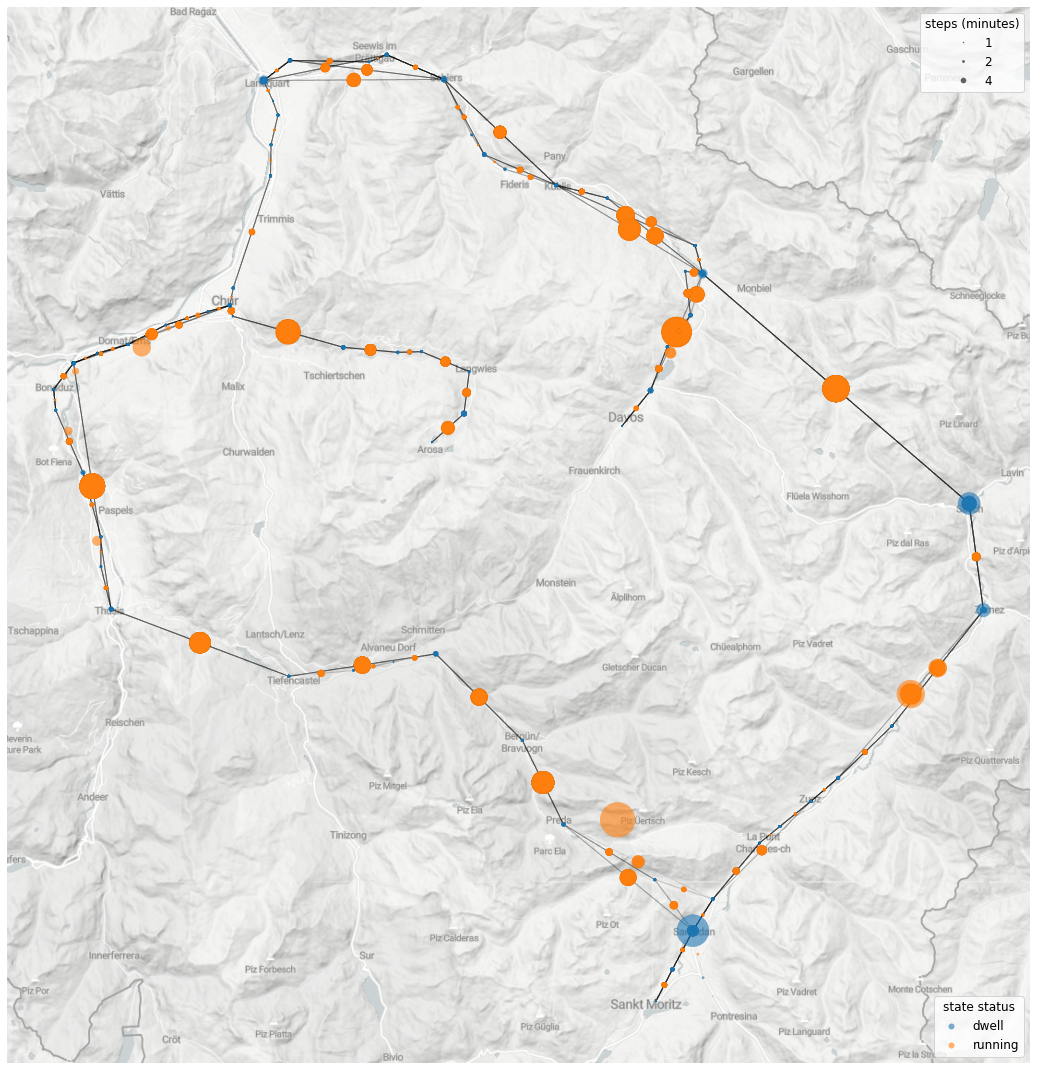

In [711]:
fig, ax = plt.subplots(figsize=(15, 15))
font = {'size': 12}
plt.rc('font', **font)

cmap = ListedColormap(cm.get_cmap("tab10").colors[:2])

for traj in tqdm(filtered.trajectories[:230]):
    # Convert to Web Mercator
    points = traj.df.to_crs(epsg=3857).drop_duplicates(subset=['geometry'])

    # Draw the lines
    lines = points.groupby(
        ['LINIEN_ID'])['geometry'].apply(lambda x: LineString(x.tolist()))
    lines = gpd.GeoDataFrame(lines, geometry='geometry')
    lines.plot(ax=ax, linewidth=1, alpha=0.03, color='black', zorder=5)

    lon = [point.x for point in points.geometry.values]
    lat = [point.y for point in points.geometry.values]

    multiplier = 2

    # Draw the points with categorical information
    scatter = ax.scatter(lon,
                         lat,
                         c=points['status'].astype('category').cat.codes,
                         s=(1 / multiplier) *
                         (points['steps'] * multiplier)**2,
                         cmap=cmap,
                         alpha=.6,
                         lw=.01,
                         ec='k',
                         zorder=10)

################################################
# END of loop
################################################

# Now draw the legends
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right",
                    title="state status")
texts = legend1.get_texts()[0].set_text('dwell')
texts = legend1.get_texts()[1].set_text('running')

ax.add_artist(legend1)

kw = dict(prop="sizes",
          color='black',
          func=lambda s: (np.sqrt(s * multiplier) / multiplier).astype(int))
legend2 = ax.legend(*scatter.legend_elements(**kw),
                    loc="upper right",
                    title="steps (minutes)")

ax.set_axis_off()
ctx.add_basemap(ax,
                attribution=False,
                source=source_detail,
                zoom=11)

path = '/home/georg/Jupyter/images/PLOS/subnet.png'
fig.tight_layout(pad=1.)
#fig.savefig(path, dpi=300, quality=90, optimize=False, progressive=True)

plt.show()
plt.close()

## Model construction

In [ ]:
# List of trajectory collection files
files = sorted(os.listdir(collection_dir))

for file in tqdm(files[10:]):
    # Import trajectory collection
    file = f'{collection_dir}{file}'
    with open(file, "rb") as f:
        unpickler = pickle.Unpickler(f)
        traj_collection = unpickler.load()
    # Find unique states for each trajectory collection
    states = []
    collection = traj_collection
    for trajectory in collection.trajectories[:]:
        unique = trajectory.df.HALTESTELLEN_NAME.unique()
        states.extend(unique)
    states = pd.DataFrame({'state': np.unique(states)})
    # Construct the raw transition matrix
    matrix = transitions(states, collection)

    timestamp = trajectory.df.BETRIEBSTAG.unique()[0].replace('.', '_')
    file = f"{matrix_dir}matrix_{timestamp}.pickle"
    # Export matrix
    with open(file, 'wb') as f:
        pickle.dump(matrix, f)

## Markovian Analysis

In [62]:
timestamps = []
dropped = []
indices = []
inflows = []
outflows = []
ranks = []
APs = []

files = sorted(os.listdir(matrix_dir))

for file in tqdm((files[:])):
    timestamp = file[7:-7]
    timestamps.append(timestamp)
    # Import raw matrix
    file = f'{matrix_dir}{file}'
    with open(file, "rb") as f:
        unpickler = pickle.Unpickler(f)
        matrix = unpickler.load()
        # Convert to sparse format
        graph = csr_matrix(matrix.values)
        # Find strongly connected component
        n_components, labels = connected_components(csgraph=graph,
                                                    directed=True,
                                                    connection='strong',
                                                    return_labels=True)
        # Keep only strongly connected
        scc = max(set(list(labels)), key=list(labels).count)
        drop = matrix.index[np.where(labels != scc)[0]]
        dropped.append(drop)
        connected_matrix = matrix.drop(labels=drop)
        connected_matrix = connected_matrix.drop(columns=drop)
        index = connected_matrix.index
        indices.append(index)

        A = connected_matrix.values
        P = A / A.sum(axis=1)[:, None]
        P = pd.DataFrame(P, columns=index.values)
        P = P.set_index(index.values)
        file = f"{P_dir}P_{timestamp}.pickle"
        with open(file, 'wb') as f:
            pickle.dump(P, f)

        # Calculate inflow
        inflow = A.sum(axis=0)
        inflow = inflow / inflow.sum()
        inflows.append(inflow)
        # Calculate outflow
        outflow = A.sum(axis=0)
        outflow = outflow / outflow.sum()
        outflows.append(outflow)

        # Compute matrix rank
        rank = LA.matrix_rank(P)
        ranks.append(rank)

        # Full calculation
        AP = Analyze(P, verbose='on', sparse=False)
        print(AP[0].min() > 0)
        APs.append(AP)

        # Calculate the Drazin inverse
        I = np.identity(P.shape[0])
        Q = drazin_inverse((I - P), tol=1e-4)
        file = f"{Drazin_dir}Q_{timestamp}.pickle"
        with open(file, 'wb') as f:
            pickle.dump(Q, f)

In [ ]:
# Serialize discarded stations
file = f"{base_dir}dropped.pickle"    
with open(file, 'wb') as f:
    pickle.dump(dropped, f)

In [ ]:
timestamps = []
remotes = []
# Get Drazin inverse files
files = sorted(os.listdir(Drazin_dir))
# Write MFPT files
MFPT_dir = f"{base_dir}MFPT/"
if not os.path.exists(MFPT_dir):
    os.makedirs(MFPT_dir)
Kemenys = []
for k, file in tqdm(enumerate(files[:])):
    timestamp = file[2:-7]
    timestamps.append(timestamp)
    file = f'{Drazin_dir}{file}'
    with open(file, "rb") as f:
        unpickler = pickle.Unpickler(f)
        Q = unpickler.load()
    # Calculate Mean First Passage Time
    n = len(indices[k])
    MFPT = np.zeros(shape=(n, n))
    for i, row in (enumerate(Q)):
        for j, _ in enumerate(row):
            if j != i:
                m = (Q[j][j] - Q[i][j]) / APs[k][0][j]
                MFPT[i][j] = m
    mfpt = pd.DataFrame(np.cbrt(MFPT), columns=indices[k].values)
    mfpt = mfpt.set_index(indices[k].values)
    remoteness = mfpt.describe().loc['mean'].values
    remotes.append(remoteness)
    file = f"{MFPT_dir}mfpt_{timestamp}.pickle"
    #print(path)
    with open(file, 'wb') as f:
        pickle.dump(mfpt, f)
    # Calculate approximate Kemeny constant
    Ks = np.zeros(shape=(n, n))
    for i in range(0, len(Q)):
        for j, m in (enumerate(MFPT[i])):
            Ks[i][j] = m * APs[k][0][j]
    # Approximate Kemeny constant
    Kemeny = Ks[:].sum() / len(Ks)
    Kemenys.append(Kemeny)

## Results

In [ ]:
vector_dir = f"{base_dir}vectors/"
if not os.path.exists(vector_dir):
    os.makedirs(vector_dir)
vectors = []

for i, timestamp in tqdm(enumerate(timestamps[:31])):
    print(i, timestamp)
    file = f"{vector_dir}vector_{timestamp}.csv" 
    # Fill in the vectors
    vector = pd.DataFrame(indices[i])
    vector = vector.set_index('state')
    vector['timestamp'] = timestamp
    vector['size'] = len(APs[i][1])
    vector['inflow'] = np.cbrt(inflows[i])
    vector['outflow'] = np.cbrt(outflows[i])
    vector['pi'] = np.cbrt(APs[i][0])
    if i in [0, 2, 4, 7, 8, 10, 11, 13, 14, 16, 19, 22, 23, 24, 26, 27, ]:
        vector['cluster'] = np.cbrt(APs[i][1])
    else:
        vector['cluster'] = -np.cbrt(APs[i][1])
    vector['remoteness'] = remotes[i]
    vector['K'] = APs[i][2]    
    vector['K_'] = Kemenys[i]
    vector['rank'] = ranks[i]
    # Geolocate vectors
    vector = gpd.GeoDataFrame(
        pd.merge(vector,
                 geolocations,
                 left_index=True,
                 right_on='HALTESTELLEN_NAME')).to_crs(epsg=3857)
    # Sort by pi
    vector = vector.sort_values(by=['pi'], ascending=True)
    vectors.append(vector)
    vector.to_csv(file, encoding='utf-8', index=False)

In [141]:
# Get vector files
vector_dir = f"{base_dir}vectors/"
vectors = []
files = sorted(os.listdir(vector_dir))
for file in (files):
    file = f'{vector_dir}{file}'
    vector = pd.read_csv(file)
    # Georeferenced locations by BPUIC
    vector = gpd.GeoDataFrame(vector,
                              geometry=gpd.points_from_xy(
                                  vector.E_WGS84,
                                  vector.N_WGS84,
                                  crs={'init': 'epsg:4326'}))
    vectors.append(vector)

In [142]:
# Load discarded stations
file = f"{base_dir}dropped.pickle"  
with open(file, "rb") as f:
    unpickler = pickle.Unpickler(f)
    dropped = unpickler.load()

In [143]:
@interact
def visual_check(i=(0, len(vectors)-1)):
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(vectors[i].stationary.values, linewidth=0.4)
    axs[0].plot(vectors[i].inflow.values, linewidth=0.4, alpha=0.9)
    axs[1].scatter(vectors[i].stationary.values, vectors[i].inflow.values, s=1, alpha=0.4)
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact'…

In [144]:
timestamps = list(pd.concat(vectors).timestamp.unique())

In [672]:
mpl.colors.to_hex('blue')

'#0000ff'

In [736]:
def status(vector, geolocations, data, ms, path):

    f, ax = plt.subplots(figsize=(15, 10))
    font = {'size': 12}
    plt.rc('font', **font)

    #alpha = 0.9
    lw = .1
    marker = 'o'

    # Convert to Web Mercator
    geolocations = geolocations.to_crs(epsg=3857)
    filter1 = geolocations['HALTESTELLEN_NAME'].isin(data)
    filter2 = geolocations['HALTESTELLEN_NAME'].isin(
        vector.HALTESTELLEN_NAME.values)
    geolocations[~filter1 & ~filter2].plot(ax=ax,
                                           marker=marker,
                                           markersize=ms,
                                           fc="grey",
                                           ec="k",
                                           lw=lw,
                                           zorder=1)
    geolocations[filter1].plot(ax=ax,
                               marker=marker,
                               markersize=ms,
                               fc="r",
                               ec="k",
                               lw=lw,
                               zorder=5)
    geolocations[filter2].plot(ax=ax,
                               marker=marker,
                               markersize=ms,
                               fc="g",
                               ec="k",
                               lw=lw,
                               zorder=10)

    # Convert back to World Geodetic System 1984
    geolocations = geolocations.to_crs(epsg=4326)

    fc = ['grey', 'r', 'g']
    labels = ['inactive', 'disconnected', 'strongly connected']
    legend_elements = []
    for i, label in enumerate(labels):
        legend_elements.append(
            Line2D([0], [0],
                   linewidth=0,
                   marker=marker,
                   color='k',
                   label=label,
                   markerfacecolor=fc[i],
                   markeredgewidth=0.5,
                   markersize=10))
    ax.legend(handles=legend_elements, loc='upper left')
    #source = ctx.providers.Esri.WorldGrayCanvas

    ctx.add_basemap(ax, attribution=False, source=source_simple, zoom=8)
    ax.set_axis_off()

    path = path
    f.tight_layout(pad=1.)
    #f.savefig(path, dpi=300, quality=90, optimize=False, progressive=True)
    plt.show()
    plt.close()

In [759]:
def show_status(date=timestamps[0]):
    markersize = 80
    path = f'/home/georg/Jupyter/images/PLOS/connectivity_{date}.png'
    i = timestamps.index(date)
    return status(vectors[i], geolocations, dropped[i], markersize, path)

In [760]:
app = interact(show_status, date=timestamps)

interactive(children=(Dropdown(description='date', options=('01_10_2019', '02_10_2019', '03_10_2019', '04_10_2…

In [666]:
columns = ['remoteness', 'stationary', 'inflow', 'outflow', 'cluster']

In [667]:
def myfmt(x, _):
    if x < 1:
        form =  '{0:+.3f}'.format(x)
    else:
        form =  '{0:+.1f}'.format(x)      
    return form

In [742]:
def mapper(vector, geolocations, column, cmap, norm, markersize, label, path):
    f, ax = plt.subplots(figsize=(15, 10))

    font = {'size': 12}
    plt.rc('font', **font)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)

    # Convert to Web Mercator
    geolocations = geolocations.to_crs(epsg=3857)
    vector = vector.to_crs(epsg=3857)
    geolocations.plot(ax=ax,
                      zorder=5,
                      markersize=markersize,
                      facecolors='grey',
                      ec='k',
                      lw=0.2)
    # Convert back to World Geodetic System 1984
    geolocations = geolocations.to_crs(epsg=4326)

    vector.plot(ax=ax,
                cax=cax,
                zorder=10,
                column=column,
                cmap=cmap,
                norm=norm,
                markersize=markersize,
                ec='k',
                lw=0.2)
    vector = vector.to_crs(epsg=4326)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    cbar = f.colorbar(sm, cax=cax, format=ticker.FuncFormatter(myfmt))
    cbar.set_label(label)
    legend_elements = [
        Line2D([0], [0],
               marker='o',
               color='k',
               label='excluded',
               markerfacecolor='grey',
               markeredgewidth=0.6,
               markersize=10,
               lw=0)
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    ctx.add_basemap(ax,
                    attribution=False,
                    source=source_simple,
                    zoom=8)
    ax.set_axis_off()

    path = path
    f.tight_layout(pad=1.)
    #f.savefig(path, dpi=300, quality=90, optimize=False, progressive=True)
    plt.show()
    plt.close()

In [755]:
def calibrate(vectors, column):
    if column == 'remoteness':
        cmap = cc.m_fire
        vmin = pd.concat(vectors).remoteness.min()
        vmax = 100
        label = 'Cube-root of the MFPT transpose'
    elif any(column in item for item in ['stationary', 'inflow' 'outflow']):
        cmap = cc.m_CET_L19
        vmin = pd.concat(vectors)[column].min()
        vmax = 0.16
        label = 'Cube-root of the first eigenvector'
    elif column == 'cluster':
        cmap = 'turbo'
        vmin = -0.49
        vmax = 0.4
        label = 'Cube-root of the second eigenvector'
    else:
        cmap = 'seismic'
        vmin = -80
        vmax = +80
        label = ''
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    return cmap, norm, label

In [761]:
def show_mapper(date=timestamps[0], column='remoteness'):
    markersize = 80
    path = f'/home/georg/Jupyter/images/PLOS/{column}_{date}.png'

    cmap, norm, label = calibrate(vectors, column)

    return mapper(vectors[timestamps.index(date)], geolocations, column, cmap,
                  norm, markersize, label, path)

In [762]:
timestamps = list(pd.concat(vectors).timestamp.unique())
app = interact(show_mapper, date=timestamps, column=columns)

interactive(children=(Dropdown(description='date', options=('01_10_2019', '02_10_2019', '03_10_2019', '04_10_2…

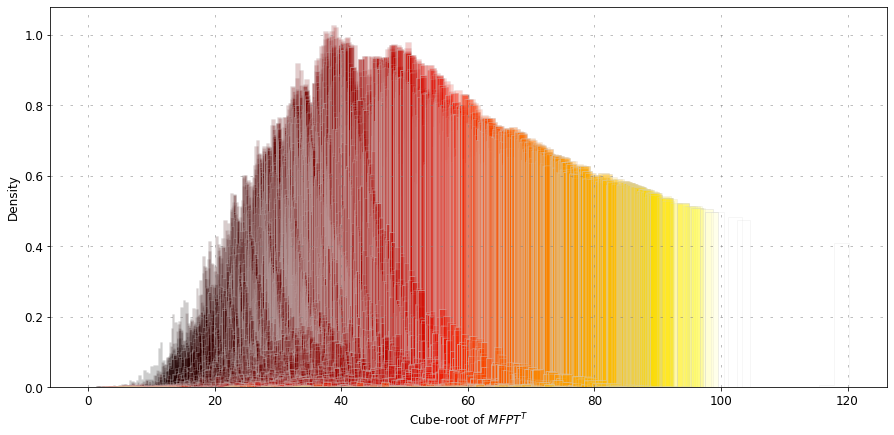

In [679]:
k=0
# Read MFPT files
MFPT_dir = f"{base_dir}MFPT/"
files = sorted(os.listdir(MFPT_dir))
file = f'{MFPT_dir}{files[k]}'
with open(file, 'rb') as f:
    unpickler = pickle.Unpickler(f)
    mfpt = unpickler.load()
remoteness = mfpt.describe().loc['mean'].values
minima = min(np.hstack(remoteness))
norm = mpl.colors.Normalize(vmin=minima, vmax=100, clip=True)
scalar = cm.ScalarMappable(norm=norm, cmap=cc.m_fire)
colors = []
for i in remoteness:
    colors.append(scalar.to_rgba(i))
colors = np.array(colors)
fig = plt.figure(figsize=(15, 7))
font = {'size': 12}
plt.rc('font', **font)
bins = 50
order = np.argsort(remoteness)
for i, c in tqdm(zip(order, colors[order])):
    plt.hist(mfpt.values.T[i],
             density=True,
             color=c,
             bins=bins,
             alpha=0.2,
             histtype='stepfilled',
             ec='lightgrey')
plt.ylabel('Density')
plt.xlabel('Cube-root of $MFPT^{T}$')
plt.grid(linewidth=.5, color='gray', linestyle=(0, (5, 15)))
plt.show()
plt.close()

In [680]:
all_vecs = pd.concat(vectors)
all_vecs = all_vecs.reset_index()

In [681]:
count = all_vecs.groupby('timestamp').count().values.T[0]
counts = all_vecs[['timestamp', 'size', 'rank', 'K',
                   'K_']].drop_duplicates(subset='timestamp')
counts['count'] = count
counts['total'] = len(geolocations)
counts = counts.reset_index(drop=True)

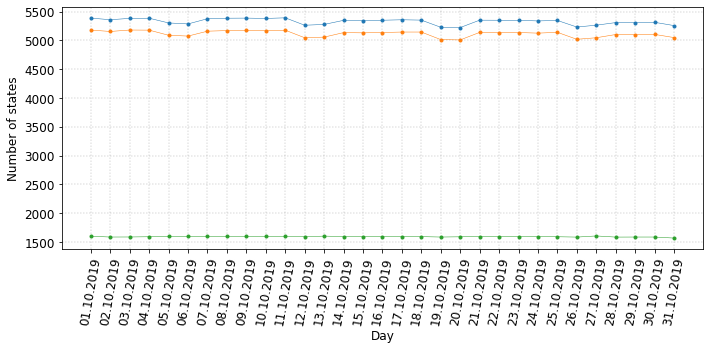

In [682]:
# Plot size
fig = plt.figure(figsize=(10, 5))
plt.plot(counts['size'], '.-', linewidth=.51)
plt.plot(counts['rank'], '.-', linewidth=.51)
#plt.plot(counts['total'], '.-', linewidth=.51)
plt.plot(counts['count'], '.-', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Number of states')
plt.xlabel('Day')
xticks = [s.replace('_', '.') for s in counts.timestamp]
plt.xticks(range(len(counts)),
           xticks,
           rotation=80,
           horizontalalignment='center')

plt.grid(linewidth=.3, color='gray', linestyle=(0, (5, 5)))

#path = '/home/georg/Jupyter/images/Fig1.png'
fig.tight_layout(pad=1.)
#fig.savefig(path, dpi=300, quality=90, optimize=False, progressive=True)

plt.show()
plt.close()

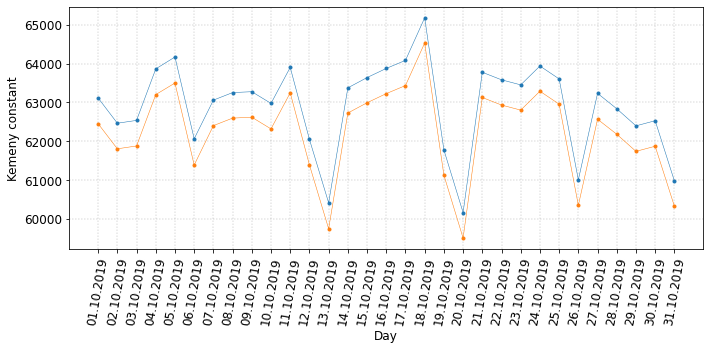

In [683]:
# Plot size
fig = plt.figure(figsize=(10, 5))
plt.plot(counts.K, '.-', linewidth=.51)
plt.plot(counts.K_, '.-', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Kemeny constant')
plt.xlabel('Day')
xticks = [s.replace('_', '.') for s in counts.timestamp]
plt.xticks(range(len(counts)),
           xticks,
           rotation=80,
           horizontalalignment='center')

plt.grid(linewidth=.3, color='gray', linestyle=(0, (5, 5)))

#path = '/home/georg/Jupyter/images/Fig1.png'
fig.tight_layout(pad=1.)
#fig.savefig(path, dpi=300, quality=90, optimize=False, progressive=True)

plt.show()
plt.close()

In [684]:
def row_based_idx(num_rows, num_cols, idx):
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

In [685]:
def plotter(vectors,
            column):
    cmap, norm, _ = calibrate(vectors, column)
    num_cols = 5
    num_rows = 7

    #fontsize = 20
    font = {'size': 20}
    plt.rc('font', **font)
    aspect = plt.rcParams['figure.figsize']
    fig, _ = plt.subplots(figsize=(24, 25))

    for i in range(2, len(vectors) + 2):

        row_based_plot_idx = row_based_idx(num_rows=num_rows,
                                           num_cols=num_cols,
                                           idx=i)
        ax = plt.subplot(num_rows, num_cols, row_based_plot_idx)
        d = i - 2
        # Convert to Web Mercator
        vector = vectors[d].to_crs(epsg=3857)
        vector.plot(ax=ax,
                    column=column,
                    cmap=cmap,
                    norm=norm,
                    markersize=20,
                    lw=0.) 

        plt.axis('off')
        plt.title(timestamps[i-2].replace('_', '.'))
    fig.tight_layout(pad=0.)

    #fig.savefig(path,
    #            dpi=150,
    #            quality=90,
    #            optimize=True,
    #            progressive=True,
    #            bbox_inches='tight')

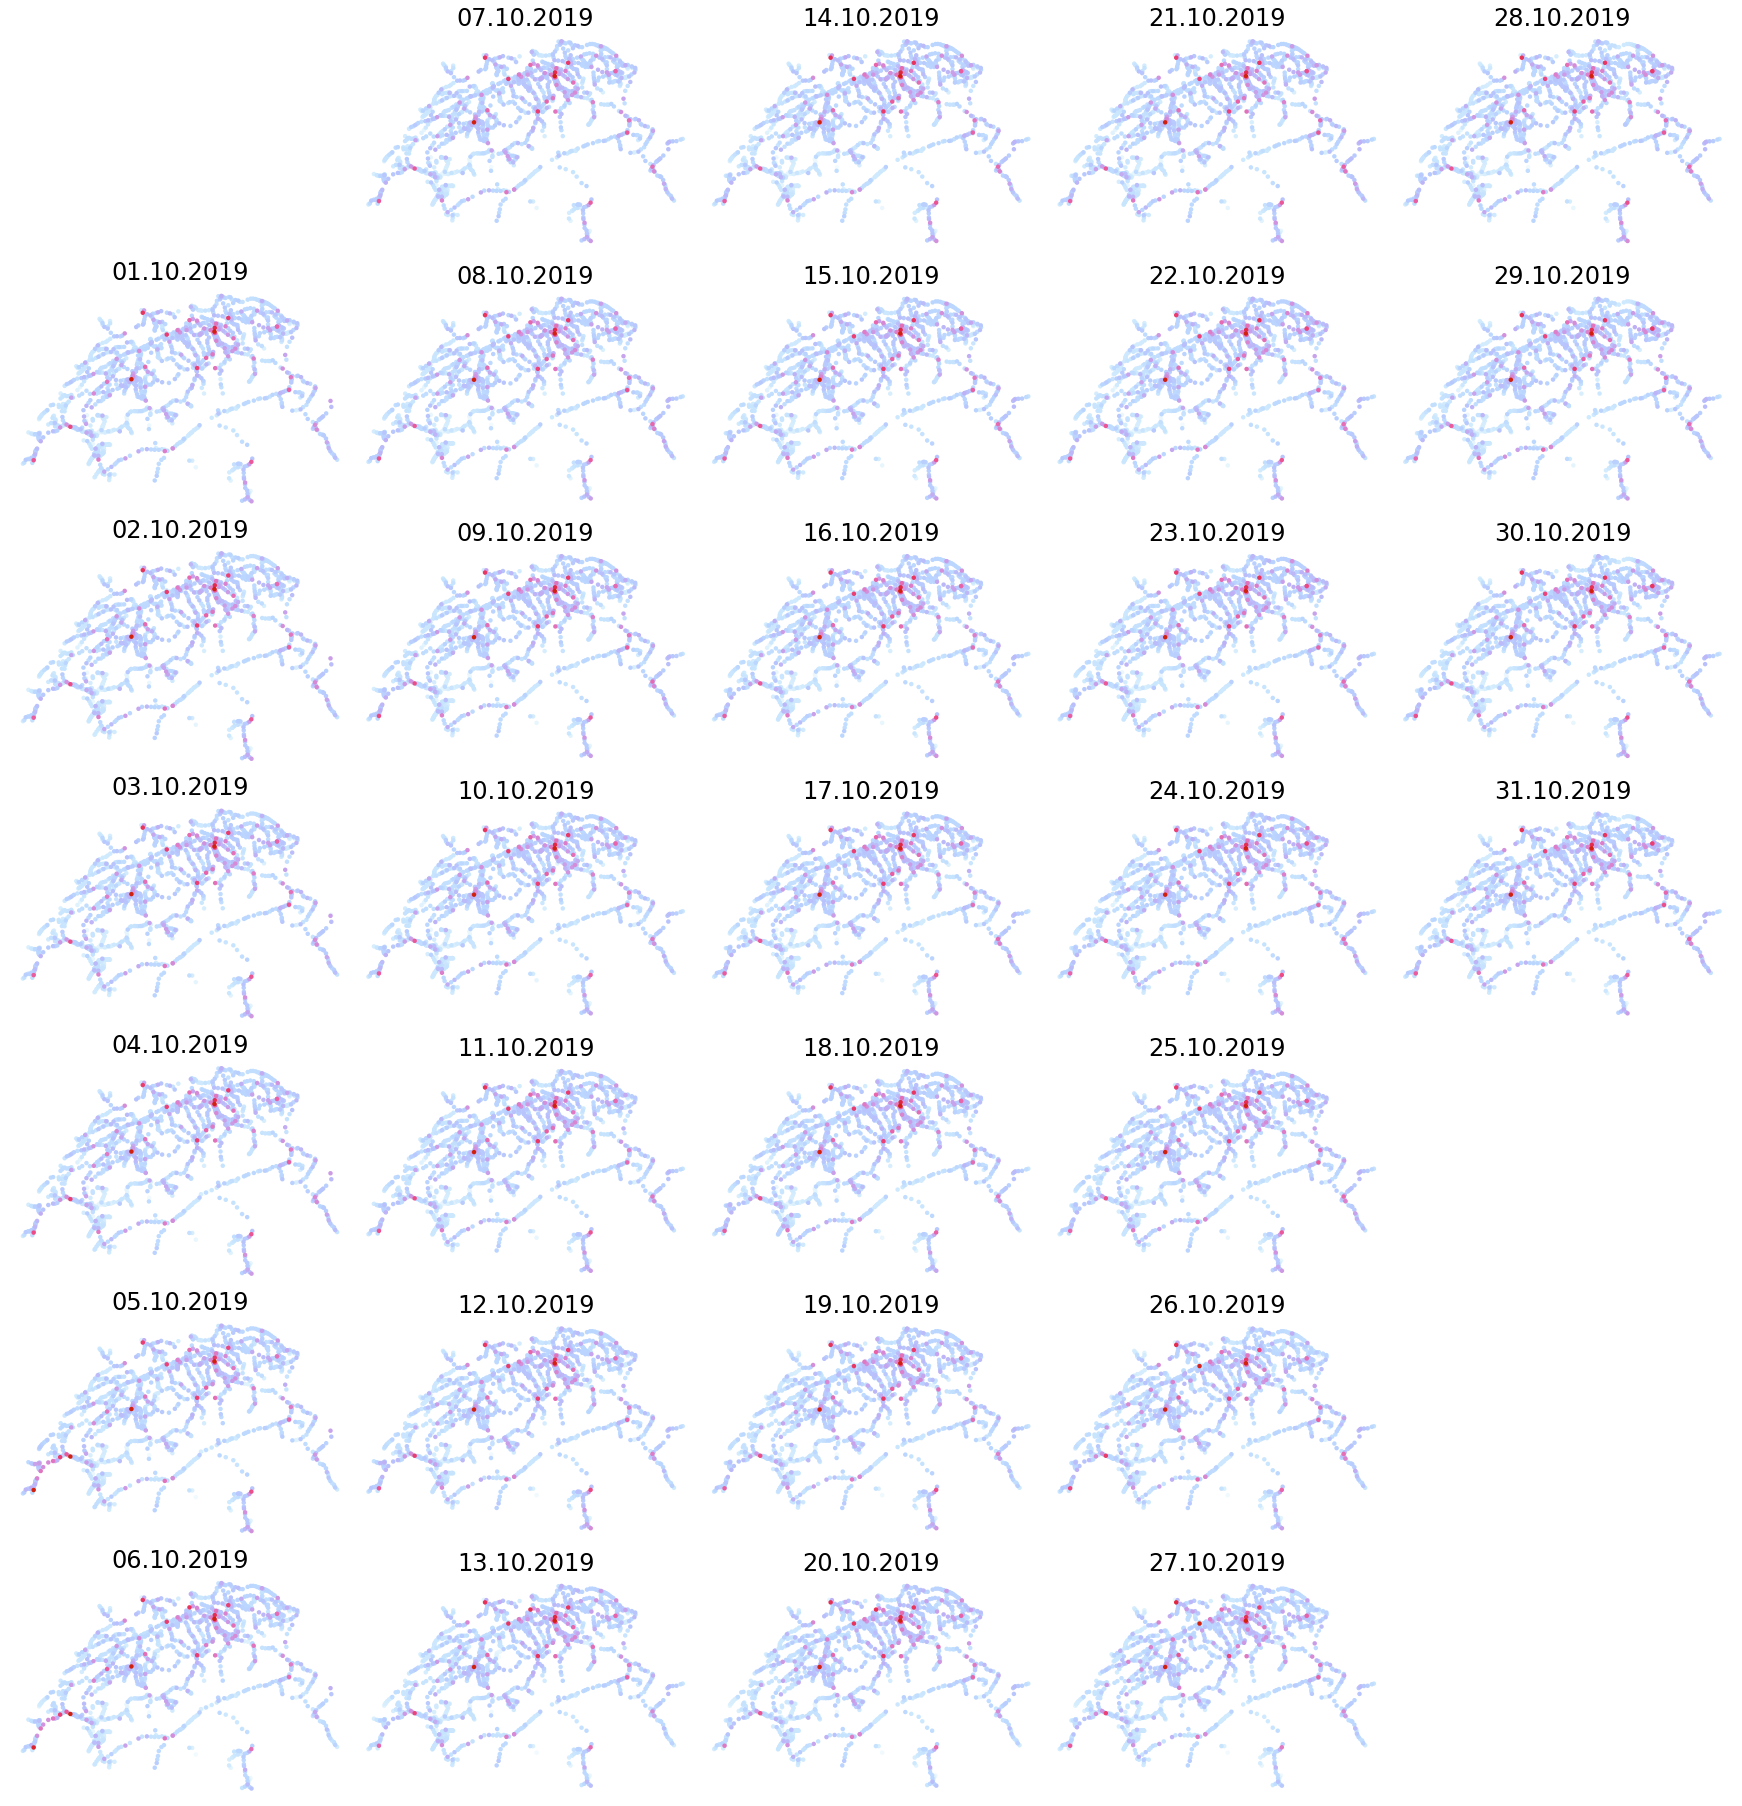

In [686]:
plotter(vectors, 'stationary')

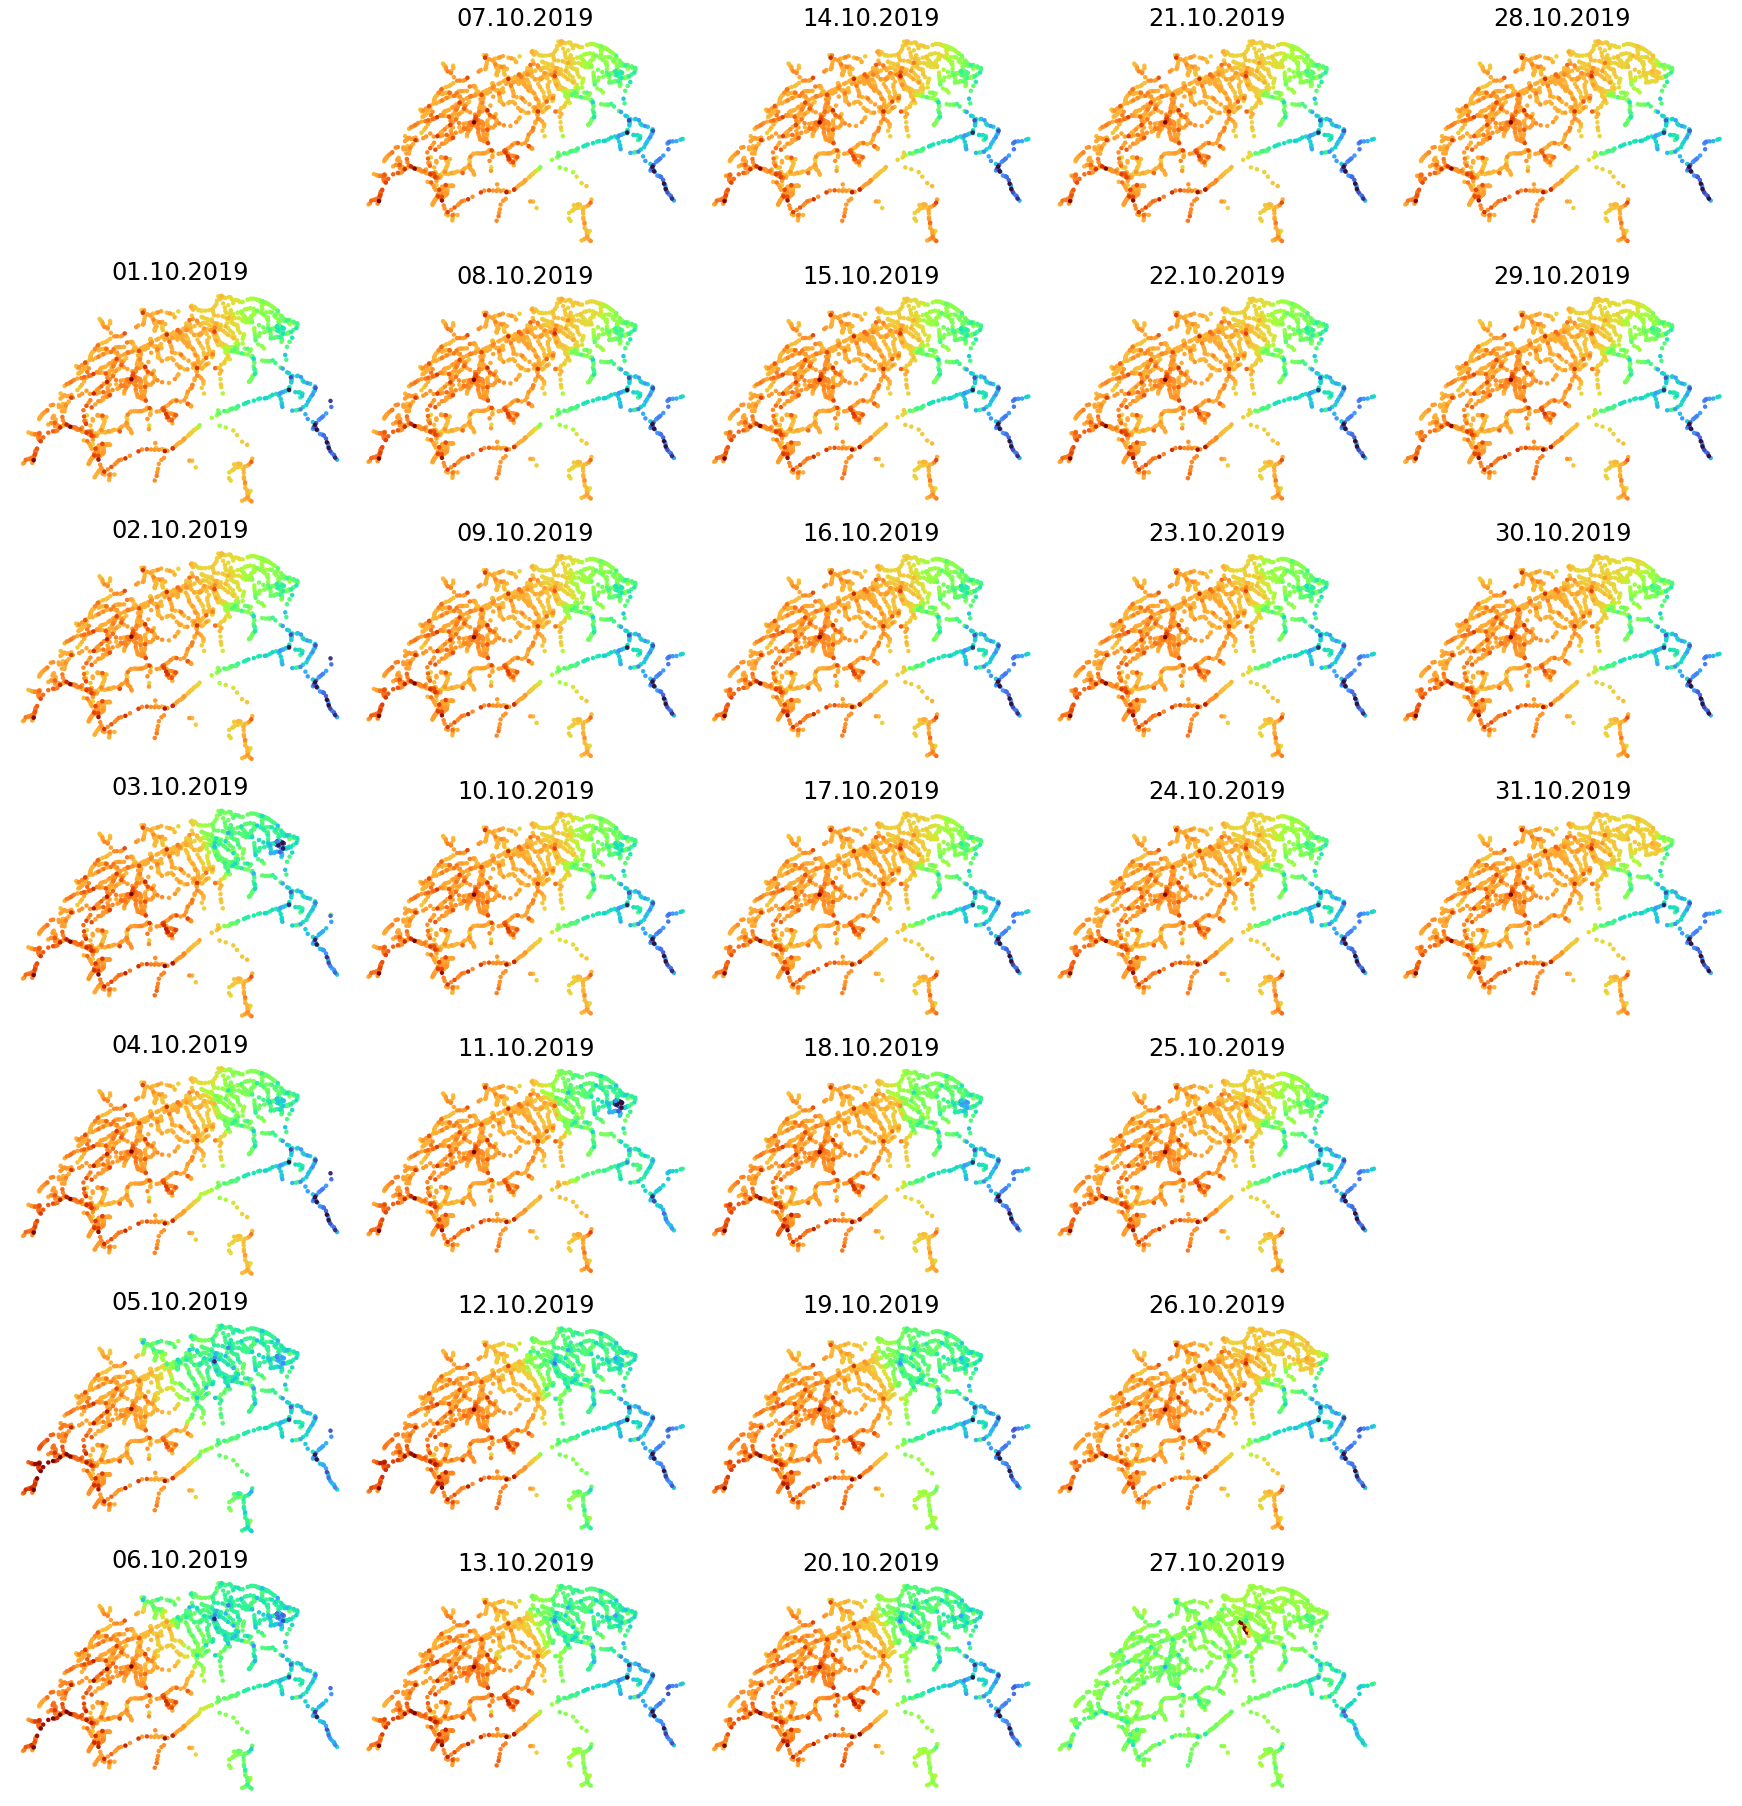

In [687]:
plotter(vectors, 'cluster')

## Sensitivity analysis of Markov chains

In [688]:
# Simultaneous Perturbation on incoming edges
def perturb(M, i, p):

    MC = M.copy()
    n = MC.shape[0]
    
    ei = np.zeros(shape=[n, 1])
    ei[i][0] = 1

    ep = np.zeros(shape=[n, 1])
    subtotal = 0
    for r in p:
        subtotal += MC[i][r]
    for r in p:
        ep[r][0] = MC[i][r] / subtotal
        
    fraction = subtotal / (1 - subtotal)

    if subtotal < 1:
        P = fraction * np.dot(ei, (np.dot(ei.T, MC) - ep.T))
    elif len(p)== 1 and subtotal == 1:
        P = np.zeros(shape=[n, n])
        P[i,i] = 1
        P[i,p[0]] = -1
    elif len(p)== 2 and subtotal == 1:
        P = np.zeros(shape=[n, n])
        P[i,i] = 1
        P[i,p[0]] = -MC[i,p[0]]
        P[i,p[1]] = -MC[i,p[1]]
        
    return P

### Validation on Toy Matrix

In [ ]:
# Modified Example from Kirkland
E = np.array([[0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.1, 0.5, 0.1, 0.3, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.8, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.8, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1, 0, 0]])

In [ ]:
print(perturb(E, 1, [5])[1])

In [ ]:
print(perturb(E, 7, [4,5])[7])

In [ ]:
print(perturb(E, 1, [5,6])[1])

### Compute Perturbation on the Data

Download results from https://www.dropbox.com/s/l7obr0nb7fa2v1x/Perturbations.zip?dl=0 (Obsolete!)

In [689]:
percent = -95

In [690]:
folder = 'Results'

In [691]:
files = sorted(os.listdir(P_dir))
files[0]

'P_01_10_2019.pickle'

In [692]:
file = f'{P_dir}{files[0]}'
with open(file, 'rb') as f:
    unpickler = pickle.Unpickler(f)
    P = unpickler.load()

In [693]:
perturbers = list(vectors[0].HALTESTELLEN_NAME.values)

In [694]:
perturbed = P.index

In [695]:
p = np.where(perturbed == perturbers[-2])[0][0]

In [696]:
# States directly connected with target
inbound = list(np.asarray(np.where(P.values[:, p] > 0))[0])
if p in inbound:
    inbound.remove(p)

In [697]:
# States indirectly connected with target
incoming = []
# Search for the incoming
for n, i in enumerate(inbound):
    coel = list(np.asarray(np.where(P.values[:, i] > 0))[0])
    if i in coel:
        coel.remove(i)
    #coel = [e for e in coel if e not in rogue]

    if '=>' in perturbed[i]:
        print('Indirect:', perturbed[coel[0]], perturbed[i])
        incoming.append(coel[0])
    else:
        print('Direct:', perturbed[i], perturbed[p])
        inbound[n] = p
        incoming.append(i)

Indirect: Belp Belp=>Bern
Indirect: Bern  Europaplatz Bern  Europaplatz=>Bern
Indirect: Bern Bümpliz Nord Bern Bümpliz Nord=>Bern
Indirect: Bern Europaplatz Bern Europaplatz=>Bern
Indirect: Bern Felsenau Bern Felsenau=>Bern
Indirect: Bern Stöckacker Bern Stöckacker=>Bern
Indirect: Bern Wankdorf Bern Wankdorf=>Bern
Indirect: Burgdorf Burgdorf=>Bern
Indirect: Düdingen Düdingen=>Bern
Indirect: Flamatt Flamatt=>Bern
Indirect: Fribourg/Freiburg Fribourg/Freiburg=>Bern
Indirect: Gümmenen Gümmenen=>Bern
Indirect: Jegenstorf Jegenstorf=>Bern
Indirect: Kerzers Kerzers=>Bern
Indirect: Konolfingen Konolfingen=>Bern
Indirect: Lyss Lyss=>Bern
Indirect: Münsingen Münsingen=>Bern
Indirect: Olten Olten=>Bern
Indirect: Thun Thun=>Bern
Indirect: Worblaufen Worblaufen=>Bern
Indirect: Zofingen Zofingen=>Bern
Indirect: Zürich Altstetten Zürich Altstetten=>Bern
Indirect: Zürich HB Zürich HB=>Bern


In [698]:
# Match incoming to a list of inbounds
default = defaultdict(list)
for key, value in zip(incoming, inbound):
    default[key].append(value)
dictionary = dict(default)

# Reserved for debugging
debug = True
if debug:
    for k, v in dictionary.items():
        print(perturbed[k], list(perturbed[v]))

Belp ['Belp=>Bern']
Bern  Europaplatz ['Bern  Europaplatz=>Bern']
Bern Bümpliz Nord ['Bern Bümpliz Nord=>Bern']
Bern Europaplatz ['Bern Europaplatz=>Bern']
Bern Felsenau ['Bern Felsenau=>Bern']
Bern Stöckacker ['Bern Stöckacker=>Bern']
Bern Wankdorf ['Bern Wankdorf=>Bern']
Burgdorf ['Burgdorf=>Bern']
Düdingen ['Düdingen=>Bern']
Flamatt ['Flamatt=>Bern']
Fribourg/Freiburg ['Fribourg/Freiburg=>Bern']
Gümmenen ['Gümmenen=>Bern']
Jegenstorf ['Jegenstorf=>Bern']
Kerzers ['Kerzers=>Bern']
Konolfingen ['Konolfingen=>Bern']
Lyss ['Lyss=>Bern']
Münsingen ['Münsingen=>Bern']
Olten ['Olten=>Bern']
Thun ['Thun=>Bern']
Worblaufen ['Worblaufen=>Bern']
Zofingen ['Zofingen=>Bern']
Zürich Altstetten ['Zürich Altstetten=>Bern']
Zürich HB ['Zürich HB=>Bern']


In [699]:
N = P.shape[0]

In [700]:
# Perturbation factor
t = -percent / 100

In [701]:
# Perturbation of Transition Matrix
PM = np.zeros(shape=[N, N])
for k, v in dictionary.items():
    PM += t * perturb(P.values, k, v)
PM += P

In [704]:
AP = Analyze(P, verbose='on', sparse=True)
print(AP[0].min() > 0)

Analysis in 3.668213129043579
True


In [703]:
APM = Analyze(PM, verbose='on', sparse=True)
print(APM[0].min() > 0)

Analysis in 2.8099632263183594
True


In [705]:
PDF = 100 * (APM[0] - AP[0]) / AP[0]

In [706]:
# P_diff
DF = pd.DataFrame(
    index=perturbed , data=np.asarray(PDF), columns=[perturbers[-2]])

In [707]:
vectors[0]['perturber'] = DF.loc[perturbers].Bern.values

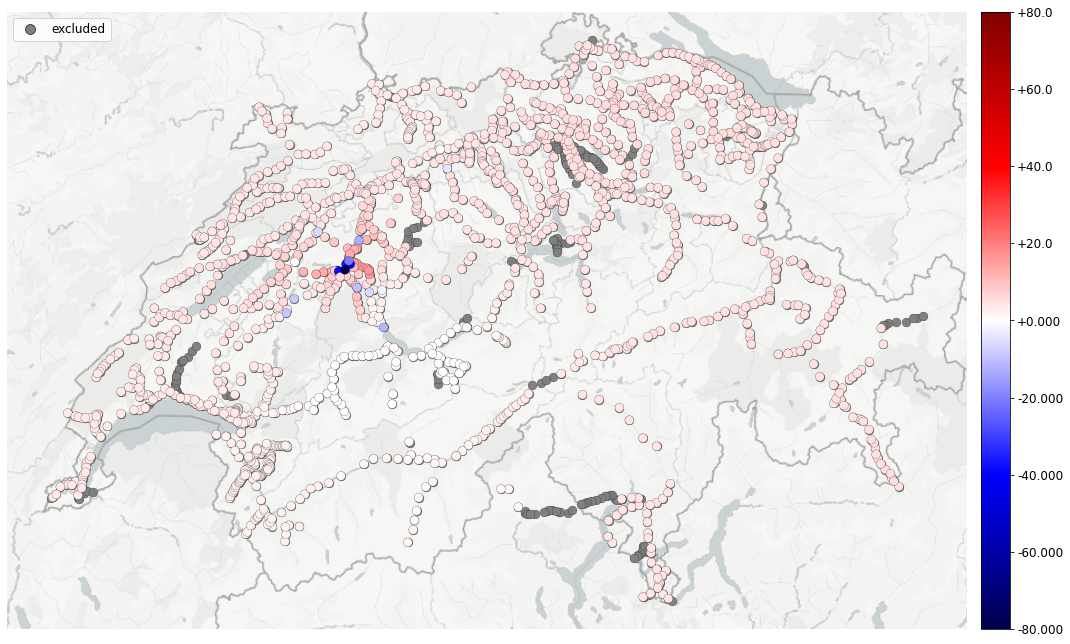

In [763]:
cmap, norm, label = calibrate(vectors[0], 'perturber')
path = ''
mapper(vectors[0], geolocations, 'perturber', cmap, norm, 80, label, path)

In [ ]:
# perturbers = list(indices)
# 
# # P corresponds to Perron eigenvector
# # K corresponds to Kemeny constant
# 
# for d in range(0, len(TMs)):
#     TM = TMs[d].values
#     N = TMs[d].shape[0]
#     perturbed = TMs[d].index
# 
#     P_normal = ATMs[d][0]
#     K_normal = ATMs[d][2]
# station
#     P_perturbed = []
#     P_diff = []
#     K_diff = []
# 
#     for station in tqdm(perturbers):
#         p = np.where(perturbed == station)[0][0]
# 
#         # States directly connected with target
#         inbound = list(np.asarray(np.where(TM[:, p] > 0))[0])
#         if p in inbound:
#             inbound.remove(p)
#         # States indirectly connected with target
#         incoming = []
#         # Absorbing states with teleportation
#         rogue = []
# 
#         # Search and exclude absorbing states
#         for i in inbound:
#             roel = list(np.asarray(np.where(TM[i, :] > 0))[0])
#             if len(roel) > 1000:
#                 rogue.append(i)
#                 inbound.remove(i)
#             gc.collect()
# 
#         # Search for the incoming
#         for n, i in enumerate(inbound):
#             coel = list(np.asarray(np.where(TM[:, i] > 0))[0])
#             if i in coel:
#                 coel.remove(i)
#             coel = [e for e in coel if e not in rogue]
# 
#             if '=>' in perturbed[i]:
#                 #print('Indirect:', perturbed[coel[0]], perturbed[i])
#                 incoming.append(coel[0])
#             else:
#                 #print('Direct:', perturbed[i], perturbed[p])
#                 inbound[n] = p
#                 incoming.append(i)
# 
#             gc.collect()
# 
#         # Match incoming to a list of inbounds
#         default = defaultdict(list)
#         for key, value in zip(incoming, inbound):
#             default[key].append(value)
#         dictionary = dict(default)
# 
#         # Reserved for debugging
#         debug = False
#         if debug:
#             for k, v in dictionary.items():
#                 print(perturbed[k], list(perturbed[v]))
# 
#         # Perturbation factor
#         t = -percent / 100
# 
#         # Perturbation of Transition Matrix
#         PM = np.zeros(shape=[N, N])
#         for k, v in dictionary.items():
#             PM += t * perturb(TM, k, v)
#         PM += TM
# 
#         # Garbage collection
#         del dictionary
#         gc.collect()
# 
#         # Analytic calculation on Perturbed Matrix
#         APM = Analyze(PM, verbose='off')
#         P = APM[0]
#         K = APM[2]
#         PDF = 100 * (P - P_normal) / P_normal
#         KDF = 100 * (K - K_normal) / K_normal
# 
#         # Garbage collection
#         del PM, APM
#         gc.collect()
# 
#         P_perturbed.append(P)
#         P_diff.append(PDF)
#         K_diff.append(KDF)
# 
#     # Save to file
#     save = True
#     if save:
#         # P_normal
#         DF = pd.DataFrame(
#             index=['P_normal'],
#             data=np.asarray(P_normal)[np.newaxis, :],
#             columns=perturbed)
#         path = 'data/istdaten/{}/perturbations/{}/P_normal_{}_{:>02}{}2019.pkl'.format(
#             month, folder, str(percent), str(d + 1), imonth)
#         DF.to_pickle(path)
# 
#         # P_perturbed
#         DF = pd.DataFrame(
#             index=perturbers, data=np.asarray(P_perturbed), columns=perturbed)
#         path = 'data/istdaten/{}/perturbations/{}/P_perturbed_{}_{:>02}{}2019.pkl'.format(
#             month, folder, str(percent), str(d + 1), imonth)
#         DF.to_pickle(path)
# 
#         # P_diff
#         DF = pd.DataFrame(
#             index=perturbers, data=np.asarray(P_diff), columns=perturbed)
#         path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
#             month, folder, str(percent), str(d + 1), imonth)
#         DF.to_pickle(path)
# 
#         # K_diff
#         DF = pd.DataFrame(
#             index=perturbers,
#             data=np.asarray(K_diff),
#             columns=['Kemeny_Change_PCT'])
#         path = 'data/istdaten/{}/perturbations/{}/K_diff_{}_{:>02}{}2019.pkl'.format(
#             month, folder, str(percent), str(d + 1), imonth)
#         DF.to_pickle(path)
# 
#         # Free memory
#         del DF
#         gc.collect()
#         DF = pd.DataFrame()

### Perturbed Data

In [ ]:
def myfmt(x, pos):
    return '{0:+.2f}'.format(x)

In [ ]:
def impact(x):

    target = np.where(indices == x)[0][0]

    # Pi difference of common stations
    common_states = []

    for i, vector in enumerate(Vs):
        pi_diff_path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
            month, folder, (percent), str(i + 1), imonth)
        pi_diff = pd.read_pickle(pi_diff_path)
        pi_diff = pi_diff[list(indices)]
        _vector = vector.copy(deep=True)
        _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
        _vector['Flag'] = _vector['station'].isin(indices)
        _vector = _vector[_vector['Flag']]
        _vector['color'] = pi_diff.values[target]
        _vector.set_index('station', inplace=True)
        _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
        _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
        common_states.append(_vector)

    limit = 95

    plotter(
        dataframe=common_states,
        parameter='color',
        label='% effect on $\pi$ by a disruption at ' + x,
        path='/home/georg/Jupyter/images/{}.png'.format(x),
        norm=mpl.colors.Normalize(vmin=-limit, vmax=limit),
        flag=True)

In [ ]:
interact(
    impact,
    x=widgets.Combobox(
        value='Bern',
        placeholder='Choose station',
        options=list(indices),
        description='Station:',
        ensure_option=True,
        disabled=False));

## Calculating Systemic Influence, Systemic Fragility and other measures

In [ ]:
def myfmt(x, _):
    return '{0:+.3f}'.format(x)

In [ ]:
def influence(thresh, pi_diff, pi_normal):

    dim = pi_diff.shape[1]

    ind_pos_affecting = pi_diff.values > thresh
    ind_neg_affecting = pi_diff.values < -1 * thresh
    pos_affecting = np.zeros(dim)
    neg_affecting = np.zeros(dim)

    for i in range(dim):
        pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
            pi_normal.values[0][ind_pos_affecting[i]])
        neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
            pi_normal.values[0][ind_neg_affecting[i]])

    # We want to take out the effect each node on itself
    self_change = np.diag(pi_diff.values) * pi_normal.values[0]
    sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(self_change)

    systemic_influence = (sum_of_affecting) / float(sum_of_affecting.max())
    
    return(systemic_influence)

In [ ]:
def fragility(thresh, pi_diff, pi_normal):

    dim = pi_diff.shape[1]

    no_of_pos_affected = (pi_diff.values > thresh).sum(axis=0)
    no_of_neg_affected = (pi_diff.values < -1 * thresh).sum(axis=0)    

    systemic_fragility = (no_of_pos_affected + no_of_neg_affected -1
                         ) / float((no_of_pos_affected + no_of_neg_affected - 1).max())
    
    return(systemic_fragility)

In [ ]:
# Define threshold
thresh = 1

In [ ]:
common_states = []

for i, vector in enumerate(Vs):
    pi_normal_path = 'data/istdaten/{}/perturbations/{}/P_normal_{}_{:>02}{}2019.pkl'.format(
                month, folder, str(percent), str(i + 1), imonth)
    pi_normal = pd.read_pickle(pi_normal_path)
    pi_normal = pi_normal[list(indices)]

    pi_diff_path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
                month, folder, str(percent), str(i + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    pi_diff = pi_diff[list(indices)]
    
    K_diff_path = 'data/istdaten/{}/perturbations/{}/K_diff_{}_{:>02}{}2019.pkl'.format(
        month, folder, (percent), str(i + 1), imonth)
    K_diff = pd.read_pickle(K_diff_path).values   
    
    
    _vector = vector.copy(deep=True)    
    #_vector['power'] = pi_normal.values[0]
    _vector['$\pi_i$'] = ATMs[i][0]
    if i in [0, 3, 4, 5, 6, 8, 10, 11, 12, 13, 16, 19, 20, 23, 27, 28]:
        _vector['sub-communities'] = ATMs[i][1]
    else:
        _vector['sub-communities'] = -ATMs[i][1]
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    _vector['Flag'] = _vector['station'].isin(indices)
    _vector = _vector[_vector['Flag']]
    _vector['influence'] = influence(thresh, pi_diff, pi_normal)   
    _vector['fragility'] = fragility(thresh, pi_diff, pi_normal) 
    _vector['\u0394K'] = K_diff
    _vector.set_index('station', inplace=True)
    _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    _vector.loc[:, 'alt'] = commonloc.geopos.map(lambda x: x[2])
    common_states.append(_vector)

In [ ]:
# Compute StationRank
stationranks = []

for common in common_states:
    stationrank = common.sort_values(['influence'], ascending=False)
    stationrank = stationrank.reset_index()
    stationranks.append(stationrank)

In [ ]:
# Stationrank
@interact
def stationrank(day=(0, len(stationranks) - 1)):
    return stationranks[day].head(12)

### Systemic fragility vs. systemic influence

In [ ]:
# Median values over the whole month
ranking = pd.concat(stationranks).groupby('station').median()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
font = {'size': 12}
plt.rc('font', **font)

plt.grid(linewidth=.3, color='gray', linestyle=(0, (5, 5)), zorder=-1)
ax = plt.gca()
ax.set_xscale('linear')
ax.set_yscale('linear')
c = ranking['\u0394K'].values
order = np.argsort(c)
x = ranking.fragility.values[order]
y = ranking.influence.values[order]
z = ranking['$\\pi_i$'].values[order]
s_exp = [(n * 1e+4)**2 for n in z]
norm = mpl.colors.DivergingNorm(vmin=-1, vcenter=0, vmax=30)
order = np.argsort(c)
im = ax.scatter(x,
                y,
                c=c[order],
                s=s_exp,
                linewidth=.2,
                marker='o',
                alpha=.9,
                edgecolor=(0, 0, 0, 0.4),
                cmap='seismic',
                norm=norm,
                label='$r\propto\pi_i$',
                zorder=10)

plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))
font = {'size': 14.}
ax.autoscale(enable=True, axis='both', tight=False)
plt.rc('font', **font)
plt.tight_layout()
leg = ax.legend(loc='best',
                borderpad=2.5,
                handletextpad=3,
                framealpha=1,
                shadow=False,
                fancybox=True)
leg.legendHandles[0].set_facecolor('white')
leg.legendHandles[0].set_edgecolor('black')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)
cb = plt.colorbar(im, cax)
cb.set_label(label='\u0394K(%)', size=14, weight='normal')
plt.show()
plt.close()
path = '/home/georg/Jupyter/images/Fig6.png'
#fig.savefig(path,
#            dpi=300,
#            quality=90,
#            optimize=True,
#            progressive=True,
#            bbox_inches='tight')

### Top 10

In [ ]:
Rank = ranking.sort_values(['$\pi_i$'], ascending=False)
Rank = Rank.reset_index()
Rank.head(10)

### Bottom 10

In [ ]:
_Rank = ranking.sort_values(['$\pi_i$'], ascending=True)
_Rank = _Rank.reset_index()
_Rank.head(10)

### Top 10 most influential

In [ ]:
influenceRank = ranking.sort_values(['influence'], ascending=False)
influenceRank = influenceRank.reset_index()
influenceRank.head(10)

### Top 10 less influential

In [ ]:
_influenceRank = ranking.sort_values(['influence'], ascending=True)
_influenceRank = _influenceRank.reset_index()
_influenceRank.head(10)

### Top 10 most fragile

In [ ]:
fragilityRank = ranking.sort_values(['fragility'], ascending=False)
fragilityRank = fragilityRank.reset_index()
fragilityRank.head(10)

### Top 10 less fragile

In [ ]:
_fragilityRank = ranking.sort_values(['fragility'], ascending=True)
_fragilityRank = _fragilityRank.reset_index()
_fragilityRank.head(10)

### Top 10 with highest positive impact on Kemeny constant

In [ ]:
KemenyRank = ranking.sort_values(['\u0394K'], ascending=False)
KemenyRank = KemenyRank.reset_index()
KemenyRank.head(10)

### Top 10 with highest negative impact on Kemeny constant

In [ ]:
_KemenyRank = ranking.sort_values(['\u0394K'], ascending=True)
_KemenyRank = _KemenyRank.reset_index()
_KemenyRank.head(10)

In [ ]:
R = Rank.head(10).station.values
_R = _Rank.head(10).station.values

In [ ]:
iR = influenceRank.head(10).station.values
_iR = _influenceRank.head(10).station.values

In [ ]:
fR = fragilityRank.head(10).station.values
_fR = _fragilityRank.head(10).station.values

In [ ]:
KR = KemenyRank.head(10).station.values
_KR = _KemenyRank.head(10).station.values

In [ ]:
A = common_states[0].index.values

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0],
           marker='o',
           color='w',
           label='high',
           markerfacecolor='r',
           markersize=10),
    Line2D([0], [0],
           marker='o',
           color='w',
           label='low',
           markerfacecolor='b',
           markersize=10)
]

num_cols = 4
num_rows = 1
fontsize = 20

fig, axes2d = plt.subplots(nrows=num_rows,
                           ncols=num_cols,
                           sharex=True,
                           sharey=True,
                           figsize=(21, 4))

for i, cell in enumerate(axes2d):
    x = common_states[0].lon.values
    y = common_states[0].lat.values
    if i == 0:
        c = np.array([a in _R for a in A]).astype(int) - np.array(
            [a in R for a in A]).astype(int)
    elif i == 1:
        c = np.array([a in _KR for a in A]).astype(int) - np.array(
            [a in KR for a in A]).astype(int)
    elif i == 2:
        c = np.array([a in _iR for a in A]).astype(int) - np.array(
            [a in iR for a in A]).astype(int)
    else:
        c = np.array([a in _fR for a in A]).astype(int) - np.array(
            [a in fR for a in A]).astype(int)

    order = np.argsort(np.abs(c))

    im = cell.scatter(x[order],
                      y[order],
                      c=c[order],
                      marker='o',
                      edgecolor='black',
                      s=30,
                      linewidth=.2,
                      cmap='bwr_r',
                      alpha=1)

    cell.get_xaxis().set_ticks([])
    cell.get_yaxis().set_ticks([])
    cell.set_xlabel(['$\pi_i$', '\u0394K', 'influence', 'fragility'][i],
                    fontsize=fontsize)
    for spine in cell.spines.values():
        spine.set_visible(False)
fig.legend(handles=legend_elements,
           loc='upper left',
           borderpad=0.5,
           labelspacing=1e-1,
           shadow=False,
           fancybox=True)

fig.tight_layout(pad=0.)

path = '/home/georg/Jupyter/images/Fig8.png'
#fig.savefig(path,
#            dpi=300,
#            quality=90,
#            optimize=True,
#            progressive=True,
#            bbox_inches='tight')

### $\Delta K (\%)$ Plot

In [ ]:
plotter(
    dataframe=common_states,
    parameter='\u0394K',
    label='\u0394K(%)',
    path='/home/georg/Jupyter/images/Kemenys.jpg',
    norm=mpl.colors.DivergingNorm(vmin=-1, vcenter=0, vmax=30))

### Influence Plot

In [ ]:
plotter(
    dataframe=common_states,
    parameter='influence',
    label='Systemic Influence',
    path='/home/georg/Jupyter/images/systemic_influence.jpg',
    cmap='seismic',
    norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1))

### Fragility Plot

In [ ]:
plotter(
    dataframe=common_states,
    parameter='fragility',
    label='Systemic Fragility',
    path='/home/georg/Jupyter/images/systemic_fragility.jpg',
    norm=mpl.colors.DivergingNorm(vmin=0.2, vcenter=0.5, vmax=1))

### Non-linear normalization

In [ ]:
scaler = QuantileTransformer(
    n_quantiles=len(indices), output_distribution='uniform', random_state=0)

In [ ]:
# Compute NormalRank
normalranks = []

columns = ['inflow', 'outflow', '$\pi_i$', 'sub-communities',
           '\u0394K', 'influence', 'fragility']

for common in common_states:
    normalrank = pd.DataFrame(common, columns=columns)
    normal = scaler.fit_transform(normalrank.values)
    normalrank[:] = normal
    normalranks.append(normalrank)

In [ ]:
# Median values over the whole month
normalranking = pd.concat(normalranks).groupby('station').median()

In [ ]:
# Create a pair grid instance
font = {'size': 15}
plt.rc('font', **font)
grid = sns.PairGrid(normalranking, height=3)
grid = grid.map_lower(plt.scatter, s=20,
                      color='white', edgecolor='b', alpha=.5, lw=.4)
grid = grid.map_upper(sns.kdeplot, color='b', shade=True,
                      shade_lowest=False, alpha=0.1, n_levels=900)
grid = grid.map_diag(sns.kdeplot, shade=True, color='b', lw=.9);

path = '/home/georg/Jupyter/images/pairplot.jpg'
#grid.savefig(path, dpi=300, bbox_inches='tight')

## Descriptive Statistics

In [ ]:
minimum = pd.concat(common_states).groupby(level=0).min()

In [ ]:
maximum = pd.concat(common_states).groupby(level=0).max()

In [ ]:
median = pd.concat(common_states).groupby(level=0).median()

In [ ]:
std = pd.concat(normalranks).groupby(level=0).std()

In [ ]:
stats = [minimum, maximum, median, std]

In [ ]:
columns = ['inflow', '$\pi_i$', 'sub-communities', 
            '\u0394K', 'influence', 'fragility']

In [ ]:
num_cols = 4
num_rows = 6
metrics = columns
fontsize = 20
aspect = plt.rcParams['figure.figsize']

fig, axes2d = plt.subplots(nrows=num_rows,
                           ncols=num_cols,
                           sharex=True,
                           sharey=True,
                           figsize=(24, 21))

for i, column in enumerate(axes2d):
    for j, cell in enumerate(column):
        if j in range(0, 3) and i in range(0, 2):
            cmap = 'seismic'
            norm = mpl.colors.LogNorm(vmin=5 * 1e-6, vmax=1e-2)
            flag = False
        elif j in range(0, 3) and i == 2:
            cmap = turbo
            norm = mpl.colors.SymLogNorm(linthresh=0.001,
                                         linscale=1,
                                         vmin=-1e-1,
                                         vmax=1e-1)
            flag = True
        elif j in range(0, 3) and i == 4:
            cmap = 'seismic'
            norm = mpl.colors.LogNorm(vmin=1e-4, vmax=1)
            flag = False
        elif j in range(0, 3) and i == 5:
            cmap = 'seismic'
            norm = mpl.colors.DivergingNorm(vmin=0.2, vcenter=0.5, vmax=1)
            flag = False
        elif j in range(0, 3) and i == 3:
            cmap = 'seismic'
            norm = mpl.colors.DivergingNorm(vmin=-1, vcenter=0, vmax=30)
            flag = False
        elif j == 3:
            cmap = 'Greys'
            norm = None
            flag = False
        else:
            cmap = 'seismic'
            norm = None
            flag = False
        x = common_states[0].lon.values
        y = common_states[0].lat.values
        c = stats[j][columns[i]]

        order = np.argsort(c)
        if flag:
            order = np.argsort(-c)

        im = cell.scatter(x[order],
                          y[order],
                          c=c[order],
                          norm=norm,
                          marker='o',
                          edgecolor='black',
                          s=30,
                          linewidth=.2,
                          cmap=cmap,
                          alpha=1.0)
        if i == len(axes2d) - 1:
            cell.set_xlabel(['min', 'max', 'median', 'std'][j],
                            fontsize=fontsize)
        if j == 0:
            if i == 0:
                cell.set_ylabel('inflow ' + u"\u2248" + ' outflow',
                                fontsize=fontsize)
            elif i == 3:
                cell.set_ylabel('% \u0394K', fontsize=fontsize)
            else:
                cell.set_ylabel(columns[i], fontsize=fontsize)
        cell.get_xaxis().set_ticks([])
        cell.get_yaxis().set_ticks([])
        for spine in cell.spines.values():
            spine.set_visible(False)
        cbar = fig.colorbar(im, ax=cell)
        cbar.ax.tick_params(labelsize=15)
fig.tight_layout(pad=0.)
path = '/home/georg/Jupyter/images/Fig7.png'
#fig.savefig(path,
#            dpi=150,
#            quality=90,
#            optimize=True,
#            progressive=True,
#            bbox_inches='tight')